In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from math import sqrt
import Steerable.nn as snn

# Figure 2

### Interpolation Kernel

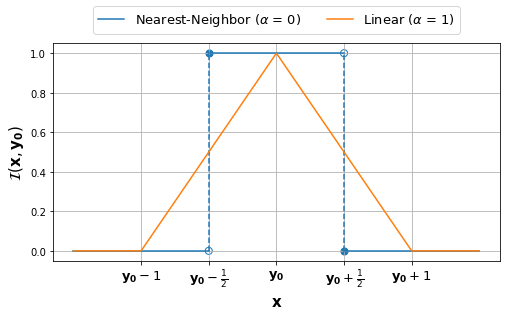

In [271]:
def I(x, y, k):
    if k == 0:
        return ((x >= y - 0.5) & (x < y + 0.5)).type(torch.float)
    else:
        d = torch.abs(x - y)
        return torch.where(d < 1, 1 - d, 0)

y0 = 0.0
epsilon = 1e-6

# Plot
plt.figure(figsize=(8, 4))

## Nearest-Neighbour
x_vals = torch.linspace(-0.5, 0.5 - epsilon, 400) 
plt.plot(x_vals, I(x_vals, y0, 0), color='C0', label=r'Nearest-Neighbor ($\alpha$ = 0)')
x_vals = torch.linspace(-1.5, -0.5 - epsilon, 400) 
plt.plot(x_vals, I(x_vals, y0, 0), color='C0', label=None)
x_vals = torch.linspace(0.5, 1.5, 400) 
plt.plot(x_vals, I(x_vals, y0, 0), color='C0', label=None)
plt.vlines(y0-0.5, 0, 1, linestyles='--')
plt.vlines(y0+0.5, 0, 1, linestyles='--')
plt.scatter([y0-0.5, y0+0.5], [1,0], marker="o", s=50)
plt.scatter([y0-0.5, y0+0.5], [0,1], marker="o", facecolors='none', edgecolors="C0", s=50)

## Linear
x_vals = torch.linspace(-1.5, 1.5, 400) 
plt.plot(x_vals, I(x_vals, y0, 1), color='C1', label=r'Linear ($\alpha$ = 1)')

# Symbolic ticks
plt.xticks([-1, -0.5, 0, 0.5, 1],
           [r"$\mathbf{y_0}-1$", r"$\mathbf{y_0}-\frac{1}{2}$", r"$\mathbf{\mathbf{y_0}}$", r"$\mathbf{y_0}+\frac{1}{2}$", r"$\mathbf{\mathbf{y_0}}+1$"],
           fontsize=13)
plt.xlabel(r"$\mathbf{x}$", size=15)
plt.ylabel(r"$\mathcal{I}(\mathbf{x}, \mathbf{y_0})$", size=15)
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.2), ncol=2, fontsize=13)
plt.grid(True)
plt.show()

# Figure 3
### Spherical grid misalignment under right angle rotation

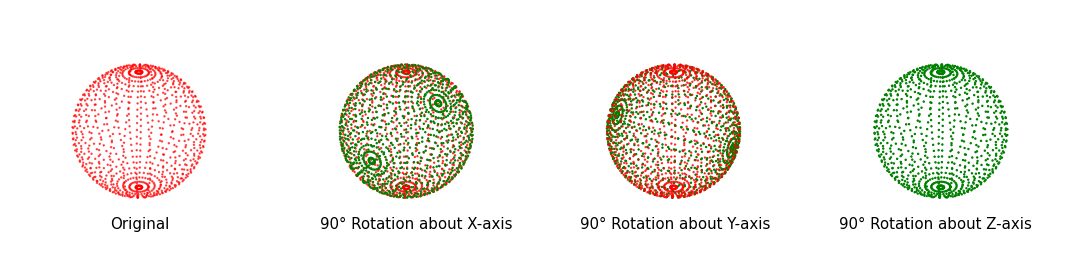

In [67]:
def spherical_grid_3d(n_angle):
    j = torch.arange(n_angle)
    theta, phi = torch.meshgrid(torch.pi * (j + 0.5) / n_angle, 2*torch.pi*(j+0.5) / n_angle, indexing='ij')
    x = (torch.sin(theta) * torch.cos(phi)).flatten()
    y = (torch.sin(theta) * torch.sin(phi)).flatten()
    z = torch.cos(theta).flatten()
    return torch.vstack([x, y, z])

def rotate_points(points, axis='x', angle_deg=90):
    angle_rad = np.radians(angle_deg)
    if axis == 'x':
        R = torch.tensor([[1, 0, 0],
                      [0, np.cos(angle_rad), -np.sin(angle_rad)],
                      [0, np.sin(angle_rad),  np.cos(angle_rad)]])
    elif axis == 'y':
        R = torch.tensor([[ np.cos(angle_rad), 0, np.sin(angle_rad)],
                      [0, 1, 0],
                      [-np.sin(angle_rad), 0, np.cos(angle_rad)]])
    elif axis == 'z':
        R = torch.tensor([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                      [np.sin(angle_rad),  np.cos(angle_rad), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    return R.type(torch.float) @ points

def plot_rotated_vs_original(n_angle):
    points = spherical_grid_3d(n_angle)
    fig, axes = plt.subplots(nrows=1, ncols=4, subplot_kw={"projection": "3d"}, gridspec_kw={'hspace':0})
    fig.set_size_inches(15,4)
    
    for ax in axes:
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        ax.set_box_aspect([1, 1, 1])
        ax.axis('off')

    # Plot original grid
    axes[0].scatter(points[0], points[1], points[2],
                color='red', s=2, alpha=0.6, label='Original')
    fig.text(0.105,0.175,s=f'Original', fontsize=15)

    for i, rotation_axis in enumerate(['x', 'y', 'z']):
        rotated = rotate_points(points, axis=rotation_axis, angle_deg=90)
        if rotation_axis in ['x', 'y']:
            # Plot original grid
            axes[i+1].scatter(points[0], points[1], points[2],
                    color='red', s=2, alpha=0.7, label='Original')

        # Plot rotated grid
        axes[i+1].scatter(rotated[0], rotated[1], rotated[2],
                   color='green', s=2, alpha=1.0, label=f'Rotated about {rotation_axis.upper()}')

        fig.text(0.24*i + 0.3,0.175,s=f'90° Rotation about {rotation_axis.upper()}-axis', fontsize=15)
        
    plt.tight_layout()
    plt.show()

# Main
plot_rotated_vs_original(32)

# Figure 4

### Error plot for rotations

## Gaussian Dataset and Equivariance Check Function

In [68]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, size, mean=0.0, std=1.0, length=1000):
        self.mean = mean
        self.std = std
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise ValueError(f'Index{idx} out of range for dataset of length {self.length}')
        image = torch.randn(self.size) * self.std + self.mean
        label = 0
        return image, label
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
degrees = torch.arange(0, 361, 5)
interpolation_orders = [0, 1, -1]
n_sim = 500

def check_equivariance(models, dataset, transfomations=None):
    models = models if type(models) is list else [models]
    transfomations = transfomations if type(transfomations) is list else [transfomations]
    values = torch.zeros(n_sim, len(models), len(transfomations), len(degrees))
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0, len(dataset), (1,)).item()][0]
        norm = torch.abs(inputs).mean()
        for i, model in enumerate(models):
            with torch.no_grad():
                for parameters in model.parameters():
                    parameters.copy_(torch.randn_like(parameters))
                for j, transfomation in enumerate(transfomations):
                    inputs_transformed = torch.stack([transfomation(inputs, degree) for degree in degrees], dim=0).to(device)
                    with torch.no_grad():
                        outputs = model(inputs.unsqueeze(0).to(device))
                        outputs_transformed = model(inputs_transformed)
                        values[sim, i, j] = 100 * (outputs-outputs_transformed).max(dim=1)[0].abs() / norm
    
        print(f'Simulation : {sim+1} / {n_sim}', end='\r')
    return torch.stack([values.mean(dim=0), values.std(dim=0)], dim=-1)
    

## 2D Model

In [69]:
# Model
class Model2D(torch.nn.Module):
    def __init__(self,interpolation_type):
        super().__init__()
        freq_cutoff = 8
        n_angle = 256
        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 4, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE2BatchNorm(),
            snn.SE2ConvType2(4, 16, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE2NormFlatten()
        )
        
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
errors_2d = check_equivariance(models=[Model2D(interpolation_type=i).to(device) for i in interpolation_orders], 
                               dataset=GaussianDataset(size =(1,28,28)), 
                               transfomations=lambda x, degree:snn.rotate_image(x, degree, order=1))

## 3D Model

In [ ]:
# Model
class Model3D(torch.nn.Module):
    def __init__(self, interpolation_type) -> None:
        super().__init__()
        n_angle = 256
        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, [4,4], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3BatchNorm(),
            snn.SE3Conv([4,4], [16,16], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3NormFlatten()
        )

    def forward(self,x):
        return self.network(x.type(torch.cfloat))

errors_3d = check_equivariance(models=[Model3D(interpolation_type=i).to(device) for i in interpolation_orders],
                               dataset=GaussianDataset(size =(1,32,32,32)), 
                               transfomations=[lambda x, degree:snn.rotate_image(x, (0, degree, 0), order=1), 
                                               lambda x, degree:snn.rotate_image(x, (degree, 0, 0), order=1)])

## Plot

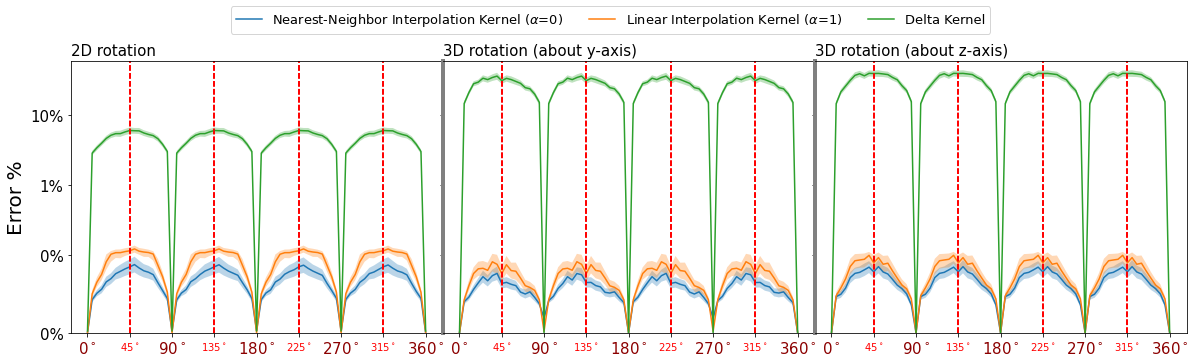

In [73]:
from matplotlib.ticker import FuncFormatter
errors = torch.cat([errors_2d, errors_3d], dim=1)
fig, axes = plt.subplots(nrows=1, ncols=errors.shape[1], sharey=True, gridspec_kw={'wspace':0})
fig.set_size_inches(20,5)


def deg_label(x):
    return rf"${x}^\circ$"


labels = [r'Nearest-Neighbor Interpolation Kernel ($\alpha$=0)',
          r'Linear Interpolation Kernel ($\alpha$=1)',
          'Delta Kernel']

for i in interpolation_orders:
    for j, ax in enumerate(axes):
        ax.plot(degrees, errors[i,j,:,0], label=labels[i])
        ax.fill_between(
            degrees,
            errors[i,j,:,0] - 1.96*errors[i,j,:,1]/sqrt(n_sim),
            errors[i,j,:,0] + 1.96*errors[i,j,:,1]/sqrt(n_sim),
            alpha=0.3
        )

        ax.set_xticks([45*i for i in range(degrees.max().item()//45 + 1)])
        ax.tick_params(axis='both', labelsize=15)
        ax.tick_params(axis='x', labelcolor='darkred')
        ticks = ax.xaxis.get_major_ticks()
        if j>0:
            ax.spines['left'].set_linewidth(4)
            ax.spines['left'].set_edgecolor('grey')
        
        for k in [1, 3, 5, 7]:
            if -len(ticks) <= k < len(ticks):
                ticks[k].label1.set_fontsize(10)
                ticks[k].label1.set_color('red')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: rf"${x}^\circ$"))
        for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
            ax.axvline(intercept, linestyle='dashed', color='red')
        ax.set_yscale('symlog', linthresh=0.1, linscale=1.0)
        ax.yaxis.set_major_formatter(PercentFormatter(100))
        ax.set_ylim((0.0, errors.max().item()+10))
        

axes[0].set_ylabel('Error %', size=20)
axes[0].set_title('2D rotation', loc='left', size=15)
axes[1].set_title('3D rotation (about y-axis)', loc='left', fontsize=15)
axes[2].set_title('3D rotation (about z-axis)', loc='left', fontsize=15)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.05), ncol=3, fontsize=13)

plt.show()